# ASTR 596: FDS Homework 6: Hunting for Exoplanets


### If you are watching Star Trek: Picard, then you might wonder about the "Admonition" - a warning/message left in an octuple planet system about past synthetic life in the Galaxy.

### [Ethan Siegel's Starts With a Bang blog has even covered it](https://www.forbes.com/sites/startswithabang/2020/03/19/is-star-trek-picards-hypothesized-octuple-star-system-really-possible/)

### The Kepler satellite has discovered many multi-planet systems. You can download artwork for some of them even at the [Exoplanet Travel Bureau](https://exoplanets.nasa.gov/alien-worlds/exoplanet-travel-bureau/)

<img src="Kepler-186f_small.jpg">


### But is there a system with 8 planets??? In fact, there may be at least one - [Kepler 90](https://www.nytimes.com/2017/12/14/science/eight-planets-star-system.html). This along with most other Kepler planets, were not discovered through radial velocity measurements like our example in class (i.e. that nice parameteric model doesn't apply), but were rather discovered through transits - dips in the light of the star as the planet moves around it.


<img src="Transiting-Exoplanet-Light-Curve.gif">

### You get to find 3 exoplanets in the Kepler-90 system with `gatspy`. 


### To get the Kepler data, you'll need the `lightkurve` package

> `conda install lightkurve`

### I've included some code to get the light curve, clean it and remove the NaNs, but not outliers (you can judge the wisdom of outlier removal when you are hunting for planets).


<hr>

#### Hints:

* `gatspy` has a `predict` method that you can use to get a model light curve for some period (you should need no more 3-5 terms). You might find it easier to remove the signal of each planet as you find it and work with the residual light curve to find the next.

* `lightkurve` has a bunch of useful [tutorials](https://docs.lightkurve.org/index.html)

* [The Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html) might be of help

<hr>

# Happy (planet) hunting!

In [189]:
%matplotlib inline
import lightkurve as lk
import gatspy

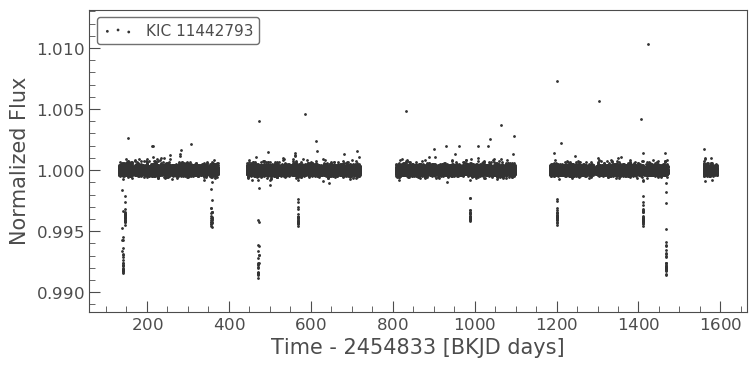

In [190]:
lcfs = lk.search_lightcurvefile('Kepler-90', mission='Kepler').download_all()

def squelch_rednoise(lc):
    corrected_lc = lc.normalize().flatten(window_length=51)
    return corrected_lc

stitched_lc = lcfs.PDCSAP_FLUX.stitch(corrector_func=squelch_rednoise)
clc = stitched_lc.remove_nans()

clc.scatter();

In [191]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import astropy.stats as st

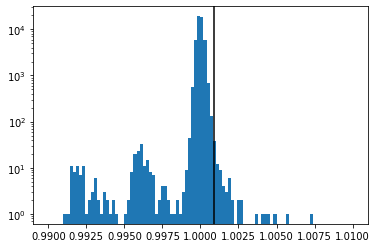

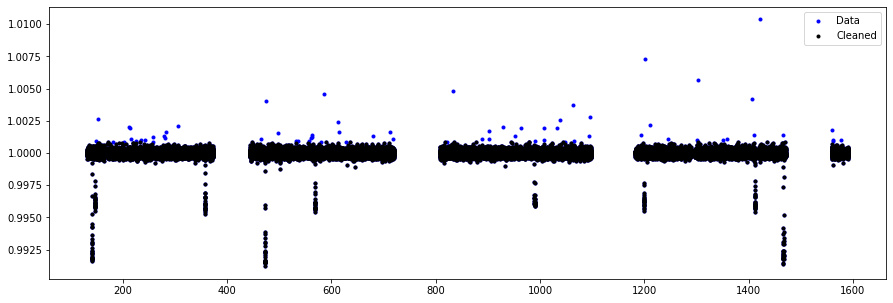

In [316]:
## visualize the flux distribution
plt.hist(clc.flux,bins=100,range=(0.990,1.01))
plt.yscale('log')

## the main peak in the center is the baseline, 
## the peaks on the left side are the transient signals (dips),
## but the data above the baseline might be outliers

lc_mean, lc_median, lc_std = st.sigma_clipped_stats(clc.flux,sigma=3.0)
ind = np.where(clc.flux<lc_median+5.*lc_std)
lc_time = clc.time[ind]
lc_flux = clc.flux[ind]
plt.axvline(x=lc_median+5.*lc_std,color='k')

plt.figure(figsize=(15,5))
plt.plot(clc.time,clc.flux,'b.',label='Data')
plt.plot(lc_time,lc_flux,'k.',label='Cleaned')
plt.legend()
plt.show()

In [193]:
model_gatspy = gatspy.periodic.LombScargle(Nterms=5)
model_gatspy.optimizer.period_range = (100, 1000)
model_gatspy.fit(lc_time,lc_flux)
period = model_gatspy.best_period
periods = model_gatspy.find_best_periods()

Finding optimal frequency:
 - Estimated peak width = 0.00431
 - Using 5 steps per peak; omega_step = 0.000861
 - User-specified period range:  1e+02 to 1e+03
 - Computing periods at 67 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00431
 - Using 5 steps per peak; omega_step = 0.000861
 - User-specified period range:  1e+02 to 1e+03
 - Computing periods at 67 steps
Zooming-in on 10 candidate peaks:
 - Computing periods at 2000 steps


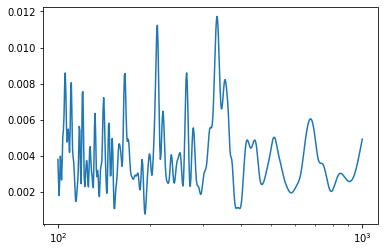

In [194]:
period_grid = np.logspace(2.,3.,num=500)
power = model_gatspy.periodogram(period_grid)
plt.plot(period_grid,power)
plt.xscale('log')

In [195]:
print('The best fit periods from gatspy are',periods[0:5])

## however, only the first two peaks are prominent in the periodogram
## try to plot the periods to verify

The best fit periods from gatspy are [333.25559853 211.9659576  165.78532503 105.6415235  264.71246273]


[Text(0, 0.5, 'flux'), Text(0.5, 0, 'phase')]

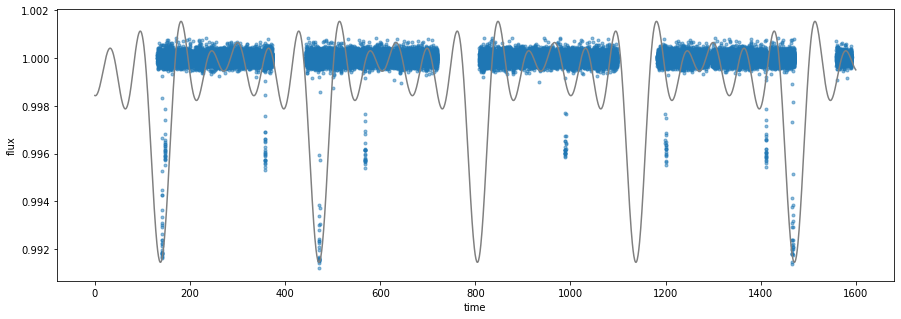

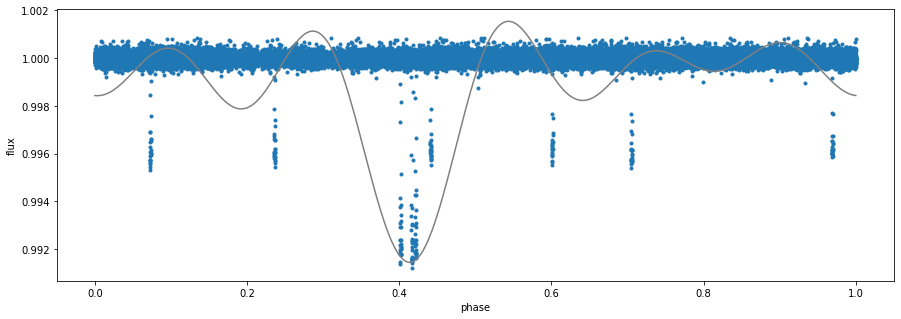

In [312]:
## plot the fitted data in time-flux space
tfit = np.linspace(0, 1600, num=2000)
ffit = model_gatspy.predict(tfit)
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(lc_time, lc_flux, '.',alpha=0.5)
ax.plot(tfit, (ffit-1.)*50+1., '-', color='gray')
ax.set(xlabel='time', ylabel='flux')

## plot the fitted data in time-flux space
tfit = np.linspace(0, periods[0], 1600)
ffit = model_gatspy.predict(tfit)
phase = (lc_time / periods[0]) % 1
phasefit = (tfit / periods[0])

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(phase, lc_flux, '.')
ax.plot(phasefit, (ffit-1.)*50+1., '-', color='gray')
ax.set(xlabel='phase', ylabel='flux')


## the 333d period aligns with the strongest dips in the data
## first planet found!

[Text(0, 0.5, 'flux'), Text(0.5, 0, 'phase')]

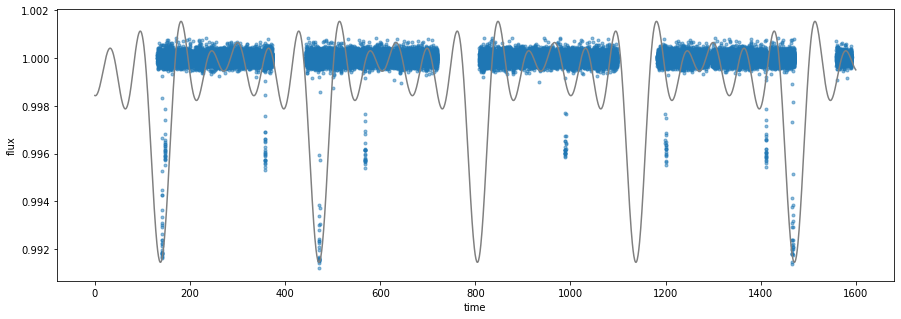

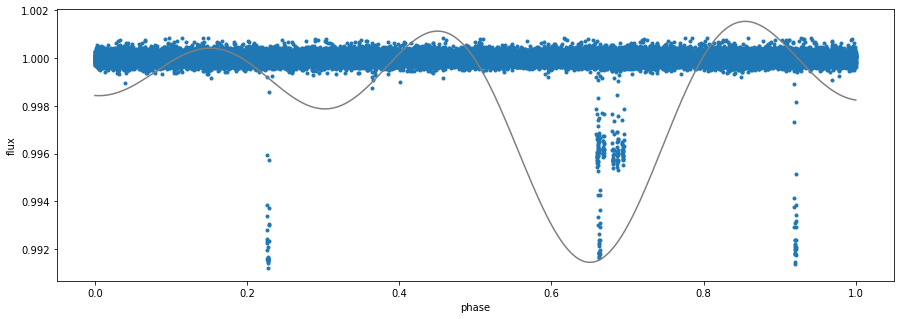

In [313]:
## plot the fitted data in time-flux space
tfit = np.linspace(0, 1600, num=2000)
ffit = model_gatspy.predict(tfit)
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(lc_time, lc_flux, '.',alpha=0.5)
ax.plot(tfit, (ffit-1.)*50+1., '-', color='gray')
ax.set(xlabel='time', ylabel='flux')

## plot the fitted data in time-flux space
tfit = np.linspace(0, periods[1], 1600)
ffit = model_gatspy.predict(tfit)
phase = (lc_time / periods[1]) % 1
phasefit = (tfit / periods[1])

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(phase, lc_flux, '.')
ax.plot(phasefit, (ffit-1.)*50+1., '-', color='gray')
ax.set(xlabel='phase', ylabel='flux')

## the 211d period seems to align with the 333d period in the data
## but it is a different peak in the phase-flux diagram, so this should also be real
## second planet found!

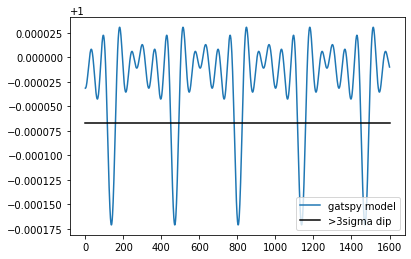

In [226]:
## to find the third planet, I mask out the strongest dip and then fit with periodogram again
## use sigma clipping on the model fit to find the time interval that has the dip
## the strongest dips are roughly flux<0.9975 judging from the histogram of all flux values
## the strongest dips are when the two planets are both transiting, 
## and the smaller dips are when only one planet transits

tfit = np.linspace(1, 1600, num=1600)
ffit = model_gatspy.predict(tfit)
plt.plot(tfit,ffit,'-',label='gatspy model')

fit_mean, fit_median, fit_std = st.sigma_clipped_stats(ffit,sigma=3.0)
#print ('3sigma dip:', fit_median-3.*fit_std)

plt.plot([0,1600],[fit_median-3.*fit_std,fit_median-3.*fit_std],'k-',label='>3sigma dip')
plt.legend(loc='lower right')

t_discard = lc_time[np.where(lc_flux<0.9975)[0]]
#print (t_discard)

## the dips roughly at 140d, 425d, 800d, 1130d, and 1470d

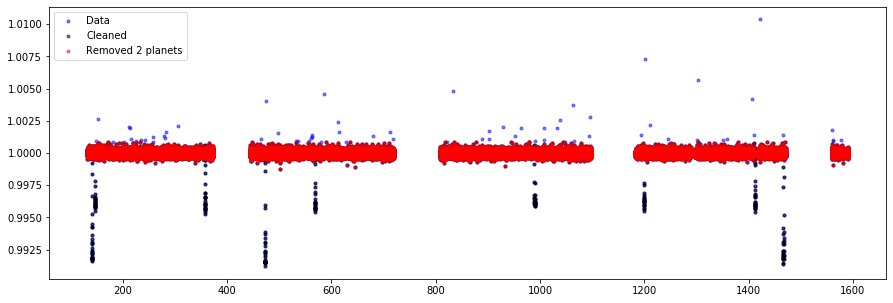

In [314]:
plt.figure(figsize=(15,5))
plt.plot(clc.time,clc.flux,'b.',alpha=0.5,label='Data')
plt.plot(lc_time,lc_flux,'k.',alpha=0.5,label='Cleaned')

discard = np.zeros(len(lc_time))
for i in range(len(t_discard)):
    ind = np.where(np.abs(lc_time-t_discard[i])<1.)[0]
    discard[ind]=1.
    
lc_time_res = lc_time[np.where(np.all([discard==0],axis=0))]
lc_flux_res = lc_flux[np.where(np.all([discard==0],axis=0))]
plt.plot(lc_time_res,lc_flux_res,'r.',alpha=0.5,label='Removed 2 planets')
plt.legend()
plt.show()

In [280]:
## repeat the periodogram process for the third planet
model_gatspy_res = gatspy.periodic.LombScargle(Nterms=1)
model_gatspy_res.optimizer.period_range = (50, 300)
model_gatspy_res.fit(lc_time_res,lc_flux_res)
period_res = model_gatspy_res.best_period
periods_res = model_gatspy_res.find_best_periods()
print('The best fit periods from gatspy are',periods_res)

Finding optimal frequency:
 - Estimated peak width = 0.00431
 - Using 5 steps per peak; omega_step = 0.000861
 - User-specified period range:  50 to 5e+02
 - Computing periods at 133 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00431
 - Using 5 steps per peak; omega_step = 0.000861
 - User-specified period range:  50 to 5e+02
 - Computing periods at 133 steps
Zooming-in on 10 candidate peaks:
 - Computing periods at 2000 steps
The best fit periods from gatspy are [ 60.8450677  162.76266437  68.53678342  63.68594054  77.79388093]


First three peaks from periodogram: [60.82121469 60.96156258 60.68118992]


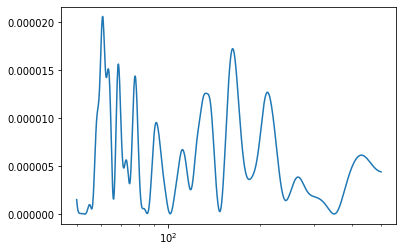

In [315]:
period_grid_res = np.logspace(np.log10(50),np.log10(500),num=1000)
power_res = model_gatspy_res.periodogram(period_grid_res)
plt.plot(period_grid_res,power_res)
plt.xscale('log')
print('First three peaks from periodogram:',period_grid_res[np.argsort(-power_res)[:3]])

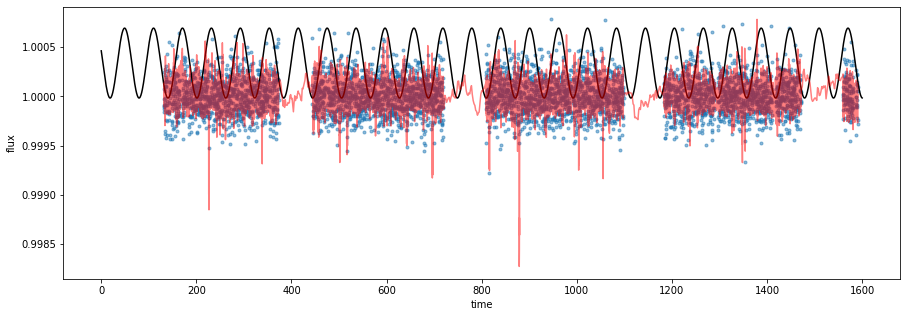

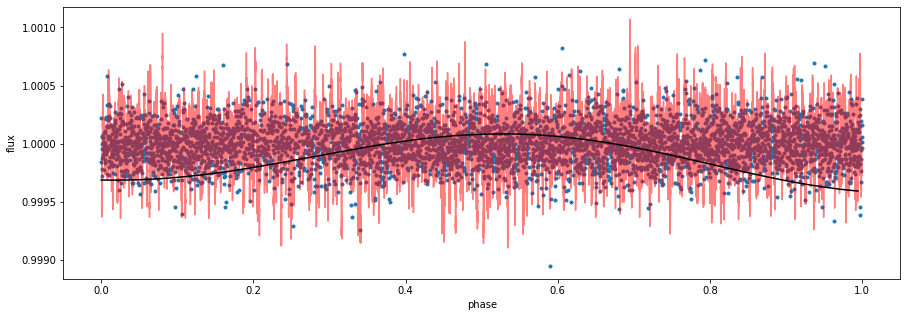

In [309]:
## plot the fitted data in time-flux space
tfit_res = np.linspace(0, 1600, num=2000)
ffit_res = model_gatspy_res.predict(tfit_res)
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(lc_time_res[::10], lc_flux_res[::10], '.',alpha=0.5)
ax.plot(tfit_res, (ffit_res-1.)*300+1., '-', color='k')
ax.set(xlabel='time', ylabel='flux')
## plot binned data
lc_flux_bin = [np.mean(lc_flux_res[i:i+50]) for i in range(len(lc_flux_res)-50)]
lc_time_bin = [np.mean(lc_time_res[i:i+50]) for i in range(len(lc_time_res)-50)]
ax.plot(lc_time_bin,(np.array(lc_flux_bin)-1.)*10+1,'r-',alpha=0.5)

## plot the fitted data in time-flux space
tfit_res = np.linspace(0, periods_res[0], 1600)
ffit_res = model_gatspy.predict(tfit_res)
phase_res = (lc_time_res / periods_res[0]) % 1
phasefit_res = (tfit_res / periods_res[0])

ind = np.argsort(phase_res)
phase_res = phase_res[ind]
lc_flux_res = lc_flux_res[ind]
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(phase_res[::10], lc_flux_res[::10], '.')
ax.plot(phasefit_res[::10], (ffit_res[::10]-1.)*10+1., '-', color='k',zorder=10)
ax.set(xlabel='phase', ylabel='flux')

np.argsort(phase_res)
phase_res_bin = [np.mean(phase_res[i:i+50]) for i in range(len(phase_res)-50)]
lc_flux_bin = [np.mean(lc_flux_res[i:i+50]) for i in range(len(lc_flux_res)-50)]
ax.plot(phase_res_bin,(np.array(lc_flux_bin)-1.)*10+1,'r-',alpha=0.5)

## The periodogram and gatspy fit on the residual light curve shows the strongest period is ~60d
## Again, I plot the best fit gatspy model on the residual light curve
## The signal is not very clear directly from the data, but you can see it after binning the data (red curve)


## The three planets I found have periods of ~333d, ~211d and ~60d, 
## and my results match the data on the NASA exoplanet archive.